# Metody inteligencji obliczeniowej - Sprawozdanie 7

## Algorytmy genetyczne.
### Yuliya Zviarko, 23.04.2025

# Wprowadzenie
W przeciwieństwie do klasycznych metod optymalizacyjnych, które często analizują jedno rozwiązanie naraz i poruszają się po przestrzeni rozwiązań przy pomocy wyznaczonych reguł, algorytmy genetyczne przeszukują wiele rozwiązań równolegle w sposób częściowo losowy. Dzięki temu są bardziej odporne na lokalne minima i lepiej sprawdzają się w złożonych, wielowymiarowych przestrzeniach decyzyjnych.

Algorytmy genetyczne naśladują naturalne procesy – naturalny dobór, krzyżowanie i mutacje – w celu ewolucji rozwiązań problemów. Każde możliwe rozwiązanie danego zagadnienia jest zapisywane jako "chromosom", a ich kolekcja tworzy populację. Pokolenie po pokoleniu rozwiązania "rywalizują" ze sobą na podstawie tzw. funkcji przystosowania (fitness function), która określa, jak dobrze dane rozwiązanie radzi sobie z zadaniem postawionym.


# Zadanie 1

W zadaniu pierwszym należało zaproponować swoją implementację algorytmu genetycznego w celu znalezienia maksimum funkcji
$$
f(x) = \cos(80x + 0.3) + 3x^{-0.9} - 2
$$  

w przedziale $[0.01, 1]$.


Dla $x = 0$, choć nie powinno być używane w zadaniu, przyjmujemy $f(x) = 0$.


Celem zadania było porównanie działania algorytmu w różnych wariantach:
* Dla kodowania w naturalnym kodzie **binarnym** i w kodzie **Graya**
* Dla szansy mutacji wynoszącej **0, 0.1, 0.5 i 1.0**
* Dla selekcji **ruletkowej** i dla selekcji **progowej**. W selekcji progowej dzielimy populację na dwie grupy: na $\gamma\%$ najlepszych i na pozostałych. Osobniki w grupie $\gamma\%$ najlepszych mają równą szansę na reprodukcję, pozostałe mają zerową szansę na reprodukcję. Wyniki nałeżalo sprawdzić dla $\gamma = 30$ i $\gamma = 60$.


Za każdym razem należało podać średnie wyniki dla 10 wywołań algorytmu i przedstawić przykładowe przebiegi algorytmu na wykresach (tylko dla jednego z wywołań).

Na samym początku sprawdziłam w WolframAlpha, jak wygląda wykres zadanej funkcji. Jest to kawałek hiperboli dla dodatnich osi $x$ i $y$.

Zatem maksimum tej funkcji w badanym przedziale $[0.01, 1]$ leży w punkcie $x = 0.01$, a jego wartość wynosi około 188.287.

Skoro wiemy już, jakiego wyniku mniej więcej się spodziewać, łatwiej będzie nam oszacować wyniki w trakcie badania.

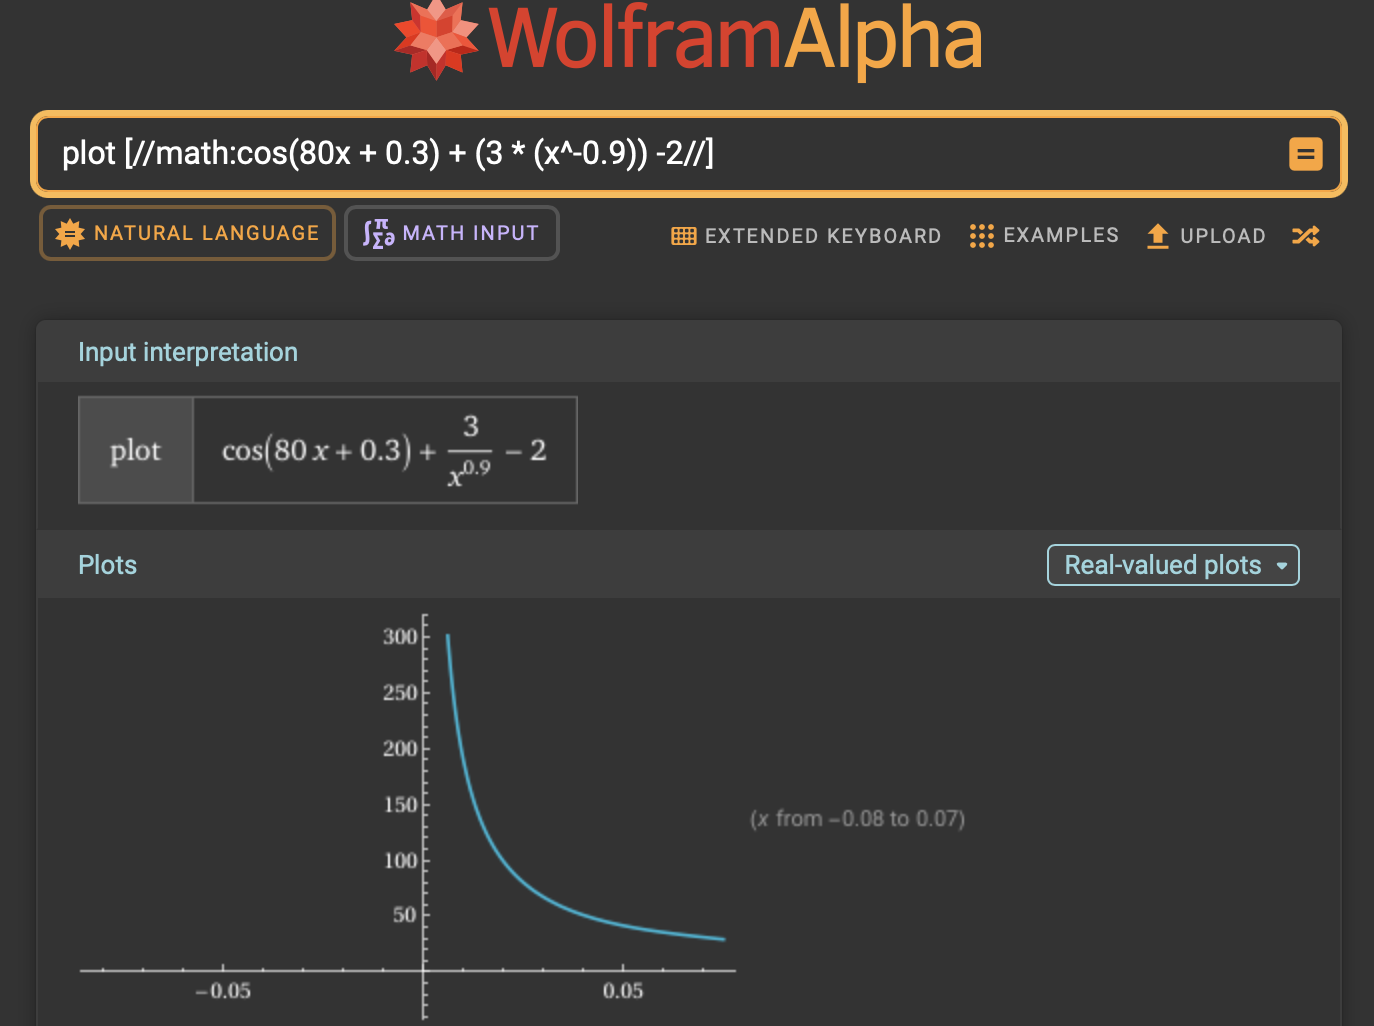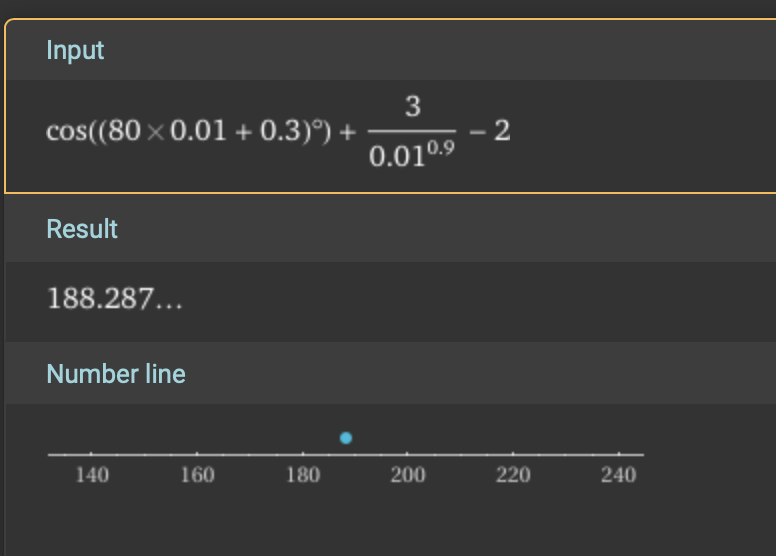

Implementacja rozpoczęła się od konwersji chromosomów, czyli ciągów bitów (potencjalnych rozwiązań), między kodowaniem binarnym a kodem Gray’a.


Jeżeli preferowany jest binary_to_gray (kod Gray’a), pierwszy bit pozostaje bez zmian, a każdy kolejny jest obliczany jako XOR (czyli ^) pomiędzy bieżącym a poprzednim bitem w zapisie binarnym.


Sytuacja jest analogiczna w przypadku gray_to_binary (kod binarny), gdzie wejściem jest zapis w kodzie Gray’a. Operacje są identyczne:

In [ ]:
import math
import random
import matplotlib.pyplot as plt

def binary_to_gray(binary):
    gray = [binary[0]]
    for i in range(1, len(binary)):
        gray.append(binary[i] ^ binary[i - 1])
    return gray

def gray_to_binary(gray):
    binary = [gray[0]]
    for i in range(1, len(gray)):
        binary.append(binary[i - 1] ^ gray[i])
    return binary

Na początku tworzona jest populacja losowych rozwiązań, która stanowi punkt wyjścia do dalszej ewolucji.
W tym celu zdefiniowałam klasę Solution – nasze pojedyncze rozwiązanie.

* Kiedy tworzy się nowy obiekt tej klasy, metoda __init__ generuje losowe rozwiązanie (geny) o długości 16 bitów.

* Każde rozwiązanie jest oceniane pod kątem jego jakości. W tym celu zdefiniowa jest metoda **decode**, która dekoduje nasze geny (w kodzie Gray’a lub binarnym) na liczbę rzeczywistą z zakresu $[0.01, 1]$.

* Metoda **fitness** pomaga w ocenie jakości rozwiązania. Stosujemy w niej zaproponowaną funkcję:
$$
f(x) = \cos(80x + 0.3) + 3x^{-0.9} - 2
$$  

* Metoda **crossover** – miesza geny w losowym punkcie dwóch połączonych rozwiązań. Dwa wybrane osobniki wymieniają fragmenty swojego „genotypu”, tworząc nowe kombinacje cech.

* Metoda **mutate** – zmienia losowo niektóre bity w zależności od podanego mutation_rate. W tym miejscu będziemy podstawiać zaproponowane w treści zadania wartości 0, 0.1, 0.5 i 1.0. Losowe zmiany w niektórych genach wprowadzają różnorodność i przeciwdziałają przedwczesnemu zbieganiu się populacji.

Cały proces powtarza się przez wiele pokoleń, a populacja z czasem „uczy się”, jak znajdować coraz lepsze rozwiązania:

In [ ]:
class Solution:
    def __init__(self, gene_length=16, randomize=False, use_gray=False):
        self.gene_length = gene_length
        self.use_gray = use_gray
        if randomize:
            self.genes = [random.randint(0, 1) for _ in range(gene_length)]
        else:
            self.genes = [0] * gene_length

    def decode(self):
        genes = self.genes
        if self.use_gray:
            genes = gray_to_binary(genes)
        value = int("".join(str(bit) for bit in genes), 2)
        x = 0.01 + (value / (2 ** self.gene_length - 1)) * (1 - 0.01)
        return x

    def fitness(self):
        x = self.decode()
        if x == 0:
            return 0
        return math.cos(80 * x + 0.3) + 3 * (x ** -0.9) - 2

    def crossover(self, other):
        point = random.randint(1, self.gene_length - 1)
        child = Solution(self.gene_length, use_gray=self.use_gray)
        child.genes = self.genes[:point] + other.genes[point:]
        return child

    def mutate(self, mutation_rate):
        for i in range(self.gene_length):
            if random.random() < mutation_rate:
                self.genes[i] ^= 1

Lepsze rozwiązania mają większe szanse na „rozmnożenie się” w kolejnej generacji. W tym celu mamy dwa rodzaje selekcji, które będą osobno testowane: selekcję **ruletkową** oraz selekcję **progową**.

Selekcja ruletkowa jest metodą stochastyczną, w której prawdopodobieństwo wyboru osobnika jest proporcjonalne do jego jakości (fitness). Metoda ta jest inspirowana rzeczywistymi ruletkami, ale posiada istotne różnice w porównaniu do nich. Jak wiadomo z filmów o kasynach i hazardzie, ruletki mają sloty o jednakowej wielkości. Oznacza to, że wszystkie sloty mają takie samo prawdopodobieństwo bycia wybranymi. Zamiast tego, w implementacji selekcji ruletkowej stosuje się wersję ważoną. Im większa jakość osobnika, tym większa szansa, że zostanie on wybrany do rozmnożenia:





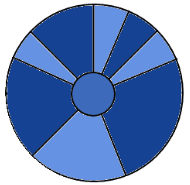

Pierwszym składnikiem metody selekcji ruletkowej jest zatem to, że jakość osobnika jest proporcjonalna do prawdopodobieństwa jego wyboru.



Jednak to nie wystarcza. Ponieważ populacja składa się z *n* osobników, suma prawdopodobieństw $\sum_{i=1}^n p_i $ ich wyboru musi wynosić 1. W związku z tym musimy również znormalizować wszystkie wartości prawdopodobieństw do przedziału $[0, 1]$.


Dla threshold_selection(selekcja progowa) najpierw osobniki są sortowane malejąco według fitness,
następnie wybierana jest tylko górna część populacji – np. 30% najlepszych (określane przez próg gamma).
Losowanie następuje tylko wśród tej elity, reszta jest odrzucana.

Wedlug treści zadania w danej selekcji dzielimy populację na dwie grupy: na  𝛾%  najlepszych i na pozostałych. Osobniki w grupie  𝛾%  najlepszych mają równą szansę na reprodukcję, pozostałe mają zerową szansę na reprodukcję. Wyniki będziemy sprawdzać dla  𝛾=30  i  𝛾=60.

In [ ]:
def roulette_selection(population, fitnesses):
    total_fitness = sum(fitnesses)
    if total_fitness == 0:
        return random.choices(population, k=2)
    selection_probs = [f / total_fitness for f in fitnesses]
    return random.choices(population, weights=selection_probs, k=2)

def threshold_selection(population, fitnesses, gamma):
    sorted_population = [x for _, x in sorted(zip(fitnesses, population), key=lambda pair: pair[0], reverse=True)]
    cutoff = max(2, int(len(population) * gamma / 100))
    selected = sorted_population[:cutoff]
    return random.choices(selected, k=2)


Na zakończenie przedstawiona zostaje główna funkcja realizująca algorytm genetyczny. Tworzy ona początkową populację rozwiązań zakodowanych binarnie lub w kodzie Graya (w zależności od parametru use_gray).

W każdej generacji obliczane są wartości przystosowania (fitness), a następnie – poprzez selekcję (ruletkową/progową), krzyżowanie i mutację (mutation_rate) – tworzona jest nowa populacja.


---

Przeprowadziłam serię eksperymentów dla różnych konfiguracji algorytmu:

Przetestowałam dwa poziomy parametru gamma (30 i 60), wpływającego na selekcję progową. Dla każdej kombinacji sposobu kodowania (binarny/Gray), metody selekcji (roulette/threshold) oraz poziomu mutacji (0.0, 0.1, 0.5, 1.0), algorytm uruchamiano 10 razy. Z każdego przebiegu został zapisany najlepszy wynik (best_fit), a następnie wyliczona średnią (avg_fit) i maksymalną (max_fit) wartość przystosowania.

start, gamma = 30
Encoding: Binary, Selection: roulette, Mutation: 0.0 -> Avg fitness: 182.3840, Max fitness: 187.7408


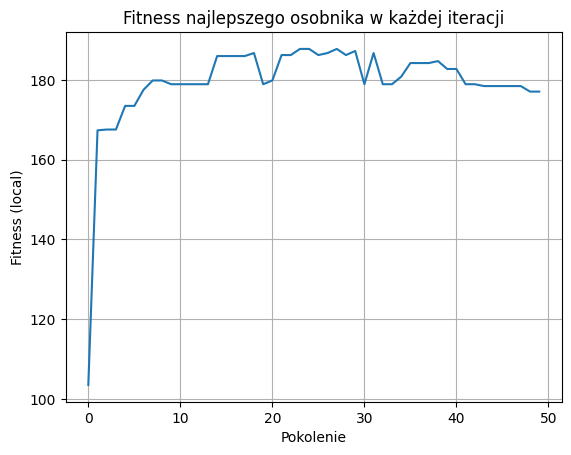

Encoding: Binary, Selection: roulette, Mutation: 0.1 -> Avg fitness: 187.7408, Max fitness: 187.7408


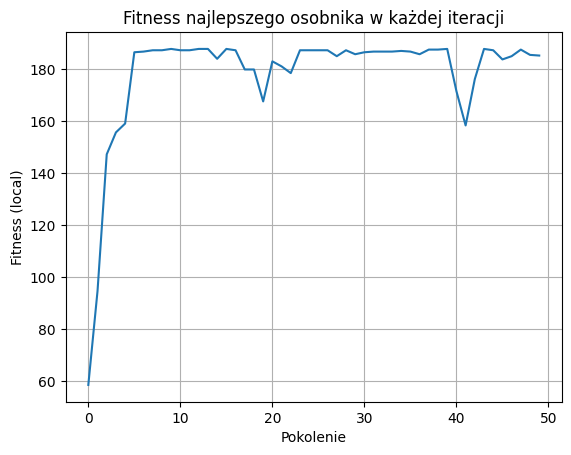

Encoding: Binary, Selection: roulette, Mutation: 0.5 -> Avg fitness: 181.3891, Max fitness: 186.9688
Encoding: Binary, Selection: roulette, Mutation: 1.0 -> Avg fitness: 143.8753, Max fitness: 187.7408
Encoding: Binary, Selection: threshold, Mutation: 0.0 -> Avg fitness: 164.4660, Max fitness: 187.7408
Encoding: Binary, Selection: threshold, Mutation: 0.1 -> Avg fitness: 187.7408, Max fitness: 187.7408
Encoding: Binary, Selection: threshold, Mutation: 0.5 -> Avg fitness: 181.4445, Max fitness: 186.9688
Encoding: Binary, Selection: threshold, Mutation: 1.0 -> Avg fitness: 79.9951, Max fitness: 138.9184
Encoding: Gray, Selection: roulette, Mutation: 0.0 -> Avg fitness: 150.0197, Max fitness: 187.7408
Encoding: Gray, Selection: roulette, Mutation: 0.1 -> Avg fitness: 187.6892, Max fitness: 187.7408
Encoding: Gray, Selection: roulette, Mutation: 0.5 -> Avg fitness: 181.7104, Max fitness: 186.9688
Encoding: Gray, Selection: roulette, Mutation: 1.0 -> Avg fitness: 124.6069, Max fitness: 186.

In [ ]:
import matplotlib.pyplot as plt

print("start, gamma = 30")

plotted = 0

# Gamma = 30
for use_gray in codings:
    for selection_method in selections:
        for mutation_rate in mutations:
            fitnesses = []
            avg_sample = []
            bests_local_sample = []
            bests_global_sample = []
            for run in range(10):
                best_fit, avg_history, best_local_history = genetic_algorithm(
                    use_gray, mutation_rate, selection_method, gamma=30
                )
                fitnesses.append(best_fit)

                if run == 0:
                    avg_sample = avg_history
                    bests_local_sample = best_local_history
                    best_so_far = float('-inf')
                    for val in best_local_history:
                        best_so_far = max(best_so_far, val)
                        bests_global_sample.append(best_so_far)
            avg_fit = sum(fitnesses) / len(fitnesses)
            max_fit = max(fitnesses)
            print(f"Encoding: {'Gray' if use_gray else 'Binary'}, "
                  f"Selection: {selection_method}, "
                  f"Mutation: {mutation_rate} -> "
                  f"Avg fitness: {avg_fit:.4f}, Max fitness: {max_fit:.4f}")
            if plotted < 2:
                plt.plot(bests_local_sample)
                plt.title("Fitness najlepszego osobnika w każdej iteracji")
                plt.xlabel("Pokolenie")
                plt.ylabel("Fitness (local)")
                plt.grid(True)
                plt.show()
                plotted += 1

print("\nstart, gamma = 60")
for use_gray in codings:
    for selection_method in selections:
        for mutation_rate in mutations:
            fitnesses = []
            for run in range(10):
                best_fit, _, _ = genetic_algorithm(
                    use_gray, mutation_rate, selection_method, gamma=60
                )
                fitnesses.append(best_fit)
            avg_fit = sum(fitnesses) / len(fitnesses)
            max_fit = max(fitnesses)
            print(f"Encoding: {'Gray' if use_gray else 'Binary'}, "
                  f"Selection: {selection_method}, "
                  f"Mutation: {mutation_rate} -> "
                  f"Avg fitness: {avg_fit:.4f}, Max fitness: {max_fit:.4f}")

W większości przypadków algorytm genetyczny osiąga wyniki bliskie oczekiwanemu maksimum funkcji celu, wynoszącemu około 188,287.

Na podstawie wygenerowanych wykresów można zauważyć, że po około 10 pokoleniach wartość funkcji przystosowania praktycznie przestaje się poprawiać. Oznacza to, że populacja bardzo szybko znalazła dobre rozwiązania i nie eksplorowała już dalej przestrzeni rozwiązań.


Najlepsze rezultaty uzyskiwane są przy poziomie mutacji równym 0.1, niezależnie od zastosowanego rodzaju kodowania czy metody selekcji. Zwiększenie wartości mutacji, np. do 0.5 lub 1.0, prowadzi do pogorszenia jakości wyników.


Metoda selekcji ruletkowej (roulette selection) okazuje się bardziej stabilna przy wyższych wartościach mutacji, podczas gdy selekcja progowa (threshold selection) osiąga najlepsze wyniki przy optymalnie dobranej wartości mutacji (szczególnie przy 0.1), jednak wykazuje większą wrażliwość na jej zmiany.
Nie chcemy utracić różnorodności w populacji, ponieważ może to prowadzić do utknięcia w minimum lokalnym. Z tego względu skłaniałabym się w stronę selekcji ruletkowej, która uwzględnia całą przestrzeń rozwiązań: każdy osobnik ma szansę na wybór proporcjonalnie do swojego dopasowania.


W przypadku kodowania binarnego, np. dla liczb 15 (01111) i 16 (10000), występuje duża odległość Hammingowa wynosząca 5. Aby algorytm genetyczny przeszedł z reprezentacji 15 do 16, musiałby zmienić wszystkie bity jednocześnie. Taki problem, zwany Hamming cliffs[https://dilvanlab.github.io/old/dilvan/thesis.phd/genetic.html], stanowi trudność dla algorytmu, ponieważ zarówno mutacja, jak i krzyżowanie nie mogą łatwo pokonać tych dużych zmian.

Z tego względu kodowanie Gray’a może być korzystniejsze w trudniejszych warunkach, np. przy większych wartościach mutacji, ponieważ jest mniej podatne na powyżej opisany problem. W tym przypadku niewielkie zmiany w genotypie prowadzą do niewielkich zmian w fenotypie, co sprawia, że algorytm działa bardziej stabilnie i efektywnie.



# Zadanie 2

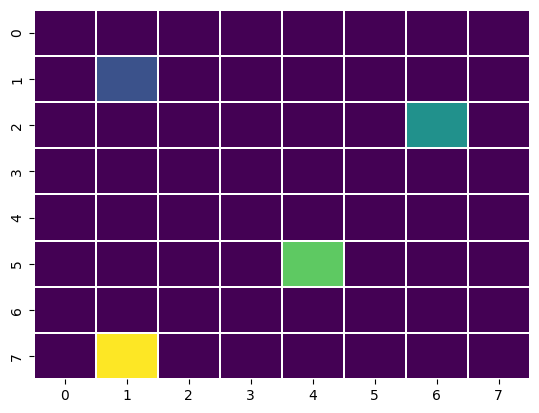

---

W mieście, reprezentowanym za pomocą kwadratowej siatki, operujemy siecią pizzerii. Ich lokalizacje znajdują się w kwadratach o pozycjach (1,1), (2,6), (5,4), (7,1), albo jak pokazano na obrazku powyżej.


Zyski sieci zależą od budżetu wyłożonego na cztery pizzerie ($B_1$, $B_2$, $B_3$, $B_4$), gdzie każdy budżet jest w zakresie od **0 do 400** (nie może wyjść poza te wartości). Zysk jest liczony w następujący sposób:

$$
Z = \sum_{i=0}^8 \sum_{j=0}^8 \frac{z_{i,j}^1 + z_{i,j}^2 + z_{i,j}^3 + z_{i,j}^4}{4} - (B_1+B_2+B_3+B_4)^{1.15}
$$

Gdzie $z_{i,j}^k$ jest dochodem $k$-tej pizzerii na polu $(i,j)$. Innymi słowy, sumujemy **średnie zyski** z danego pola dla wszystkich pizzerii i odejmujemy od tego skorygowaną (potęgowaną) sumę budżetów — ze względu na konieczność rozbudowy lokali, większe trudności w utrzymaniu itp.

Zysk $k$-tej pizzerii na polu $(i,j)$ liczymy natomiast następująco:

Najpierw liczymy $d$, czyli odległość taksówkarską (taxicab, Manhattan Distance) między pizzerią a tym polem.

- Jeżeli $d$ jest **mniejsza** niż 2:

$$
z = 1.3 \cdot \frac{B}{0.5d + 4}
$$

- Jeżeli $d$ jest **większa lub równa** 2:

$$
z = \frac{B}{0.5d + 4}
$$

---

Celem zadania drugiego było zaprojektowanie algorytmu genetycznego, którego zadaniem jest maksymalizacja wartości funkcji $Z(B_1, B_2, B_3, B_4)$.

Algorytm miał zostać przetestowany w 10 niezależnych uruchomieniach.

W ramach zadania należało samodzielnie dobrać:
* sposób kodowania osobników (rzeczywistoliczbowe, całkowitoliczbowe lub binarne),
* metodę mutacji i selekcji,
* oraz przeprowadzić eksperymenty parametryczne, by znaleźć najlepsze ustawienia algorytmu.



W klasie **Solution2** każdy osobnik reprezentuje strategię alokacji budżetu pomiędzy cztery pizzerie. Genotyp to lista czterech liczb całkowitych, określających budżet każdej pizzerii z przedziału $[0, 400]$. W odróżnieniu od zadania 1, zastosowano tutaj bezpośrednie kodowanie **całkowitoliczbowe**, zamiast kodu *binarnego* czy *Graya*.

Funkcja **przystosowania** oblicza wartość funkcji $Z$, czyli:
- Dla każdego pola $(i,j)$ w siatce $8 \times 8$ obliczany jest zysk od każdej z pizzerii na podstawie odległości Manhattan.
- Jeśli pizzeria znajduje się blisko pola (d < 2), jej wpływ na zysk jest wzmocniony przez współczynnik 1.3.
- Następnie, dla każdego pola liczony jest średni zysk z czterech pizzerii.
- Łączny zysk z całej siatki jest pomniejszany o karę za sumaryczny budżet podniesioną do potęgi 1.15.


**Krzyżowanie** osobników realizowane jest poprzez wybór losowego punktu podziału, po czym tworzony jest potomek złożony z genów dwóch rodziców. Mutacja polega na losowej zmianie wartości pojedynczego genu z ustalonym prawdopodobieństwem (0.2) na nową wartość z zakresu [0, 400].

Każdy gen (czyli wartość budżetu dla jednej pizzerii) może z pewnym prawdopodobieństwem (mutation_chance) zostać zastąpiony losową liczbą z zakresu [0, 400].


Do wyboru rodziców zastosowano selekcję **ruletkową**, gdzie szansa wyboru jest proporcjonalna do przystosowania osobnika. W przypadku, gdy suma przystosowań w populacji byłaby niedodatnia, rodzice wybierani są losowo.


Dla testowania algorytmu użyłam następujące parametry:
- Rozmiar populacji: 100
- Liczba iteracji (epok): 1000
- Prawdopodobieństwo mutacji: 0.2


Logowanie wyników odbywało się co 100 epok, prezentując:
- średnia wartość przystosowania w populacji,
- najlepszy osobnik w danej epoce,
- najlepszy osobnik w całej historii.


Po zakończeniu ewolucji wypisywany był najlepszy znaleziony osobnik oraz jego końcowa wartość funkcji przystosowania.


In [ ]:
import random
import numpy as np

class Solution2:
    def __init__(self):
        self.pizzerias = [(1, 1), (2, 6), (5, 4), (7, 1)]
        self.B = [random.randint(0, 400) for _ in range(4)]
        self.genes = self.B

    def get_adaptation(self):
        total_profit = 0
        for i in range(8):
            for j in range(8):
                avg_profit = 0
                for k in range(4):
                    x_pizzeria, y_pizzeria = self.pizzerias[k]
                    d = abs(x_pizzeria - i) + abs(y_pizzeria - j)
                    B_k = self.B[k]
                    if d < 2:
                        z = 1.3 * B_k / (0.5 * d + 4)
                    else:
                        z = B_k / (0.5 * d + 4)
                    avg_profit += z
                avg_profit /= 4
                total_profit += avg_profit

        total_budget = sum(self.B)
        adaptation = total_profit - (total_budget ** 1.15)
        return adaptation


    def crossover(self, other_solution):
        crossover_point = np.random.randint(1, 4)
        new_solution = Solution2()
        new_solution.B[0:crossover_point] = self.B[0:crossover_point]
        new_solution.B[crossover_point:] = other_solution.B[crossover_point:]
        return new_solution

    def mutation(self, mutation_chance):
        for i in range(4):
            if random.random() < mutation_chance:
                self.B[i] = random.randint(0, 400)

def selection(population):
    weights = [p.get_adaptation() for p in population]
    total_weight = sum(weights)

    if total_weight <= 0:
        # Jeśli suma wag jest zerowa lub ujemna, wybieramy losowo dwóch rodziców
        return random.choices(population, k=2)

    # Inaczej wybieramy rodziców na podstawie wag
    return random.choices(population, k=2, weights=weights)


def evolution(population, mutation_chance):
    new_population = []
    for _ in range(len(population)):
        parent1, parent2 = selection(population)
        child = parent1.crossover(parent2)
        child.mutation(mutation_chance)
        new_population.append(child)
    return new_population

population_size = 100
iterations = 1000
mutation_chance = 0.2

population = [Solution2() for _ in range(population_size)]

best_solution = Solution2()
best_solution_adaptation = 0
best_iteration_found = 0

for iteration in range(iterations):
    adaptations = [p.get_adaptation() for p in population]

    local_best_solution = population[adaptations.index(max(adaptations))]
    if local_best_solution.get_adaptation() > best_solution_adaptation:
        best_solution = local_best_solution
        best_solution_adaptation = local_best_solution.get_adaptation()
        best_iteration_found = iteration

    if iteration % 100 == 0:
        print(f"Epoch: {iteration}; avg adaptation: {sum(adaptations) / len(adaptations)}; best adaptation: {max(adaptations)} best adaptation ever: {best_solution_adaptation} from iteration {best_iteration_found}")

    population = evolution(population, mutation_chance)

adaptations = [p.get_adaptation() for p in population]
local_best_solution = population[adaptations.index(max(adaptations))]
if local_best_solution.get_adaptation() > best_solution_adaptation:
    best_solution = local_best_solution
    best_solution_adaptation = local_best_solution.get_adaptation()

print('---')
print(f'Best solution: B1: {best_solution.B[0]}, B2: {best_solution.B[1]}, B3: {best_solution.B[2]}, B4: {best_solution.B[3]}')
print(f'Found in iteration: {best_iteration_found}')
print(f'Cost: {best_solution_adaptation}')


Epoch: 0; avg adaptation: -114.59746107137927; best adaptation: 77.4849428806865 best adaptation ever: 77.4849428806865 from iteration 0
Epoch: 100; avg adaptation: -127.50754142990283; best adaptation: 84.91803655849367 best adaptation ever: 120.5303096858978 from iteration 51
Epoch: 200; avg adaptation: -98.36107024964296; best adaptation: 94.1609969502199 best adaptation ever: 120.5303096858978 from iteration 51
Epoch: 300; avg adaptation: -131.94444915092893; best adaptation: 93.9278804899277 best adaptation ever: 120.5303096858978 from iteration 51
Epoch: 400; avg adaptation: -112.42252599361518; best adaptation: 99.36131320727418 best adaptation ever: 120.5303096858978 from iteration 51
Epoch: 500; avg adaptation: -123.21592811138792; best adaptation: 77.07694274802395 best adaptation ever: 120.5303096858978 from iteration 51
Epoch: 600; avg adaptation: -93.80211173602478; best adaptation: 99.77253079818604 best adaptation ever: 120.5303096858978 from iteration 51
Epoch: 700; avg

W każdej iteracji otrzymywałam ujemne średnie wartości adaptacji - w większości przypadków osobniki w populacji generowały zbyt wysokie koszty w stosunku do uzyskanych zysków.

Już na **51** iteracji, w trakcie testów, udało się osiągnąć dobre rozwiązanie o wartości ~120,53. Pod koniec, na **721** iteracji, wartość ta poprawiła się do 121,98. Oznacza to, że wybrane kodowanie oraz zastosowane metody selekcji, mutacji i krzyżowania były wystarczająco skuteczne, by kierować populację w stronę coraz lepszych rozwiązań.
Długa stagnacja obserwowana podczas testów dla 51 iteracji, może świadczyć o osiągnięciu lokalnego optimum lub wskazywać na potrzebę dostosowania parametrów algorytmu, by wydostać się z tego optimum i zbadać inne obszary przestrzeni rozwiązań.

Najlepsze rozwiązanie osiągnięto, inwestując znaczną część budżetu w jedną pizzerię (B3 = 357), podczas gdy pozostałe otrzymały niewielkie środki. Algorytm pomógł wyznaczyć, że taka strategia przynosi największy zysk.

In [3]:
for run in range(10):
    print(f"--- Run {run + 1} ---")
    population = [Solution2() for _ in range(population_size)]
    best_solution = Solution2()
    best_solution_adaptation = 0
    best_iteration_found = 0

    for iteration in range(iterations):
        adaptations = [p.get_adaptation() for p in population]

        local_best_solution = population[adaptations.index(max(adaptations))]
        if local_best_solution.get_adaptation() > best_solution_adaptation:
            best_solution = local_best_solution
            best_solution_adaptation = local_best_solution.get_adaptation()
            best_iteration_found = iteration

        population = evolution(population, mutation_chance)

    print(f'Best solution: B1: {best_solution.B[0]}, B2: {best_solution.B[1]}, B3: {best_solution.B[2]}, B4: {best_solution.B[3]}')
    print(f'Found in iteration: {best_iteration_found}')
    print(f'Cost: {best_solution_adaptation}')


--- Run 1 ---
Best solution: B1: 7, B2: 20, B3: 302, B4: 3
Found in iteration: 842
Cost: 121.22338272319678
--- Run 2 ---
Best solution: B1: 4, B2: 18, B3: 362, B4: 2
Found in iteration: 221
Cost: 121.86478940987388
--- Run 3 ---
Best solution: B1: 3, B2: 20, B3: 297, B4: 0
Found in iteration: 616
Cost: 122.71388476446748
--- Run 4 ---
Best solution: B1: 4, B2: 9, B3: 313, B4: 4
Found in iteration: 464
Cost: 122.81410533843916
--- Run 5 ---
Best solution: B1: 2, B2: 17, B3: 325, B4: 13
Found in iteration: 906
Cost: 119.35413075421934
--- Run 6 ---
Best solution: B1: 1, B2: 5, B3: 354, B4: 5
Found in iteration: 513
Cost: 123.68431013351835
--- Run 7 ---
Best solution: B1: 4, B2: 0, B3: 290, B4: 7
Found in iteration: 445
Cost: 121.66709908288078
--- Run 8 ---
Best solution: B1: 12, B2: 5, B3: 331, B4: 5
Found in iteration: 66
Cost: 121.57331305773164
--- Run 9 ---
Best solution: B1: 5, B2: 12, B3: 341, B4: 0
Found in iteration: 231
Cost: 123.80597124077462
--- Run 10 ---
Best solution: B

In [4]:
import numpy as np

costs = [121.22, 121.86, 122.71, 122.81, 119.35, 123.68, 121.67, 121.57, 123.81, 123.00]
mean = np.mean(costs)
std_dev = np.std(costs)

print(f"Średni koszt: {mean:.2f}")
print(f"Odchylenie standardowe: {std_dev:.2f}")

Średni koszt: 122.17
Odchylenie standardowe: 1.26


Algorytm został również przetestowany w 10 niezależnych przebiegach. Jak widać, działa bardzo stabilnie, co potwierdza niskie odchylenie standardowe uzyskanych wyników. Koszty rozwiązań są spójne we wszystkich uruchomieniach, a populacja szybko koncentruje się wokół jednej klasy rozwiązań.

Warto zauważyć, że największy budżet zawsze trafia do tej samej pizzerii (B3), zatem jej lokalizacja ma dominujący wpływ na końcowy wynik. Można dalej zbadać ten efekt oraz sprawdzić, jak zmieni się wynik po wprowadzeniu dodatkowych ograniczeń lub przy innych wartościach mutacji.

W przyszłości można również przetestować inne zestawy parametrów, np. dotyczące selekcji, krzyżowania czy wielkości populacji, aby upewnić się, że uzyskane rozwiązanie jest rzeczywiście optymalne, a nie jedynie lokalnie najlepsze.